## Initial Report and Exploratory Data Analysis (EDA) 

### Overview
#### The research question you intend to answer (in one sentence, if possible):
Can we identify high-risk, medium-risk, and low-risk geographic clusters of terrorism attacks to provide pre-travel guidance using the Global Terrorism Database on Kaggle?

#### Data Source and Attribution
The analysis will use the Global Terrorism Database (GTD), available on Kaggle: https://www.kaggle.com/datasets/START-UMD/gtd. This dataset contains detailed records of over 180,000 terrorist incidents worldwide from 1970 to 2017, including date, location, weapons used, target type, and casualties.
> **Citation**:  
> National Consortium for the Study of Terrorism and Responses to Terrorism (START), University of Maryland. (2018).  *The Global Terrorism Database (GTD) [Data file].*  Retrieved from [https://www.start.umd.edu/gtd](https://www.start.umd.edu/gtd)

> **Copyright Notice**:  
> Copyright University of Maryland 2018.

> **Data Modifications**:  
> This analysis includes preprocessing of the original GTD dataset, including:
> - Filtering for relevant columns (e.g., country, region, latitude, longitude, casualties),
> - Handling missing values,
> - Creating a "casualties" column to represent attack severity.
>  
> These transformations were made solely for clustering and visualization purposes. They do not reflect any analytical decisions or interpretations made by the National Consortium for the Study of Terrorism and Responses to Terrorism (START), headquartered at the University of Maryland.

#### The techniques you expect to use in your analysis:
Data Preprocessing: Handle missing values, and filter relevant periods and columns (e.g., country, region, latitude, longitude, number of casualties, and attack type).
Exploratory Data Analysis: Visualize attack frequency by region, time trends, and severity.
Clustering Models: Since my main task is to cluster geographic regions into risk zones, I will use unsupervised learning models like K-Means or DBSCAN on spatial and severity features (e.g., latitude, longitude, casualties) to group areas into high, medium, and low-risk zones.
Visualization: Use Plotly to provide visual risk maps.

#### The expected results:
•	Creation of distinct geographic clusters that classify regions into high, medium, and low-risk zones based on historical terrorist activity.
•	Plots showing attack density and severity across continents and countries.

#### Why this question is important
The question is important because it can help travelers and organizations assess security risks for travel destinations, enhance public awareness and preparedness for travel in sensitive regions, and transform raw terrorism data into actionable intelligence for both individuals and institutions. 

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [59]:
df_orig = pd.read_csv('data\globalterrorismdb_0718dist.csv', encoding='ISO-8859-1')
df_full = df_orig.copy()
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


#### Column name and description of the dataset based on the official GTD codebook provided by START (University of Maryland). 

| Column Name                  | Description                                           |
| ---------------------------- | ----------------------------------------------------- |
| `eventid`                    | Unique ID for the event (formatted YYYYMMDDXX)        |
| `iyear`                      | Year of the incident                                  |
| `imonth`                     | Month of the incident (0 = unknown)                   |
| `iday`                       | Day of the incident (0 = unknown)                     |
| `approxdate`                 | Approximate date when the actual day is unknown       |
| `extended`                   | Whether the incident extended beyond 24 hours         |
| `resolution`                 | How the extended incident was resolved                |
| `country`                    | Numeric code for the country                          |
| `country_txt`                | Country name                                          |
| `region`                     | Numeric code for the region                           |
| `region_txt`                 | Region name                                           |
| `provstate`                  | Province, state, or administrative division           |
| `city`                       | City where the attack occurred                        |
| `latitude`                   | Latitude of the incident location                     |
| `longitude`                  | Longitude of the incident location                    |
| `specificity`                | Geographic specificity of the location                |
| `vicinity`                   | Whether the attack happened in or near the city       |
| `location`                   | Additional descriptive location info                  |
| `summary`                    | Narrative summary of the event                        |
| `crit1`                      | Criterion 1 of GTD terrorist definition met (1 = yes) |
| `crit2`                      | Criterion 2 met                                       |
| `crit3`                      | Criterion 3 met                                       |
| `doubtterr`                  | Doubt that the incident was an act of terrorism       |
| `alternative`                | Alternative explanation code                          |
| `alternative_txt`            | Text label of alternative eguncertainxplanation                 |
| `multiple`                   | Was part of multiple coordinated attacks              |
| `success`                    | Whether the attack achieved its goal                  |
| `suicide`                    | Whether it was a suicide attack                       |
| `attacktype1`                | Code for primary attack type                          |
| `attacktype1_txt`            | Description of primary attack type                    |
| `attacktype2`                | Secondary attack type code                            |
| `attacktype2_txt`            | Description of secondary attack type                  |
| `attacktype3`                | Tertiary attack type code                             |
| `attacktype3_txt`            | Description of tertiary attack type                   |
| `targtype1`                  | Code for type of first target                         |
| `targtype1_txt`              | Text label for type of first target                   |
| `targsubtype1`               | Subtype code of first target                          |
| `targsubtype1_txt`           | Subtype text of first target                          |
| `corp1`                      | Organization/company name of first target             |
| `target1`                    | Specific entity or person targeted                    |
| `natlty1`                    | Nationality code of first target                      |
| `natlty1_txt`                | Nationality of first target                           |
| `targtype2`                  | Code for type of second target                        |
| `targtype2_txt`              | Text label for type of second target                  |
| `targsubtype2`               | Subtype code of second target                         |
| `targsubtype2_txt`           | Subtype text of second target                         |
| `corp2`                      | Organization/company of second target                 |
| `target2`                    | Specific entity or person targeted (2nd target)       |
| `natlty2`                    | Nationality code of second target                     |
| `natlty2_txt`                | Nationality of second target                          |
| `targtype3`                  | Code for type of third target                         |
| `targtype3_txt`              | Text label for type of third target                   |
| `targsubtype3`               | Subtype code of third target                          |
| `targsubtype3_txt`           | Subtype text of third target                          |
| `corp3`                      | Organization/company of third target                  |
| `target3`                    | Specific entity or person targeted (3rd target)       |
| `natlty3`                    | Nationality code of third target                      |
| `natlty3_txt`                | Nationality of third target                           |
| `gname`                      | Name of the perpetrator group                         |
| `gsubname`                   | Subgroup name (if any)                                |
| `gname2`                     | Second perpetrator group                              |
| `gsubname2`                  | Subgroup of second group                              |
| `gname3`                     | Third perpetrator group                               |
| `gsubname3`                  | Subgroup of third group                               |
| `motive`                     | Suspected or known motive (free-text)                 |
| `guncertain1`                | Uncertainty about responsibility of first group       |
| `guncertain2`                | Uncertainty for second group                          |
| `guncertain3`                | Uncertainty for third group                           |
| `individual`                 | Was the attack carried out by individuals?            |
| `nperps`                     | Number of perpetrators                                |
| `nperpcap`                   | Number of perpetrators captured                       |
| `claimed`                    | First group claimed responsibility?                   |
| `claimmode`                  | Mode of claim (e.g., letter, video)                   |
| `claimmode_txt`              | Description of claim mode                             |
| `claim2`                     | Second group claim                                    |
| `claimmode2`                 | Claim mode of second group                            |
| `claimmode2_txt`             | Text for second claim mode                            |
| `claim3`                     | Third group claim                                     |
| `claimmode3`                 | Claim mode of third group                             |
| `claimmode3_txt`             | Text for third claim mode                             |
| `compclaim`                  | Were there competing claims?                          |
| `weaptype1`                  | Primary weapon type code                              |
| `weaptype1_txt`              | Primary weapon description                            |
| `weapsubtype1`               | Weapon subtype code                                   |
| `weapsubtype1_txt`           | Subtype description                                   |
| `weaptype2`                  | Secondary weapon type                                 |
| `weaptype2_txt`              | Text label for secondary weapon                       |
| `weapsubtype2`               | Secondary weapon subtype                              |
| `weapsubtype2_txt`           | Subtype text                                          |
| `weaptype3`                  | Third weapon type                                     |
| `weaptype3_txt`              | Text label for third weapon                           |
| `weapsubtype3`               | Third weapon subtype                                  |
| `weapsubtype3_txt`           | Text label                                            |
| `weaptype4`                  | Fourth weapon type                                    |
| `weaptype4_txt`              | Text label                                            |
| `weapsubtype4`               | Fourth weapon subtype                                 |
| `weapsubtype4_txt`           | Subtype description                                   |
| `weapdetail`                 | Free-text detail on weapons used                      |
| `nkill`                      | Number of people killed                               |
| `nkillus`                    | Number of U.S. nationals killed                       |
| `nkillter`                   | Number of perpetrators killed                         |
| `nwound`                     | Number of people wounded                              |
| `nwoundus`                   | Number of U.S. nationals wounded                      |
| `nwoundte`                   | Number of perpetrators wounded                        |
| `property`                   | Was property damaged?                                 |
| `propextent`                 | Extent of property damage (coded)                     |
| `propextent_txt`             | Text for property damage extent                       |
| `propvalue`                  | Estimated property damage value                       |
| `propcomment`                | Notes on property damage                              |
| `ishostkid`                  | Were hostages or kidnapped victims involved?          |
| `nhostkid`                   | Number of hostages/kidnappings                        |
| `nhostkidus`                 | Number of U.S. hostages                               |
| `nhours`                     | Duration of hostage situation in hours                |
| `ndays`                      | Duration in days                                      |
| `divert`                     | Flight diversion location (if hijacking)              |
| `kidhijcountry`              | Country involved in hijacking                         |
| `ransom`                     | Was ransom demanded?                                  |
| `ransomamt`                  | Total ransom amount demanded                          |
| `ransomamtus`                | Amount demanded in USD                                |
| `ransompaid`                 | Amount paid in local currency                         |
| `ransompaidus`               | Amount paid in USD                                    |
| `ransomnote`                 | Was a ransom note involved?                           |
| `hostkidoutcome`             | Code for hostage situation outcome                    |
| `hostkidoutcome_txt`         | Outcome description                                   |
| `nreleased`                  | Number of hostages released                           |
| `addnotes`                   | Additional notes by researchers                       |
| `scite1`, `scite2`, `scite3` | Sources used for coding                               |
| `dbsource`                   | Source database(s) used                               |
| `INT_LOG`                    | Linkage to international logistics                    |
| `INT_IDEO`                   | Linkage to international ideology                     |
| `INT_MISC`                   | Other international link                              |
| `INT_ANY`                    | Any international involvement                         |
| `related`                    | Event IDs of related attacks                          |


In [63]:
df_full.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


## Exploratory data analysis (EDA)
### Feature selection
Now I am going to remove columns step by step that are not relevant to assessing risk levels.

#### Exclude all columns like summaries, notes, and motives

In [74]:
narrative_cols = [col for col in df_full.columns if any(key in col.lower() for key in ['summary', 'motive', 'addnote', 'scite', 'notes'])]
for col in narrative_cols:
    print(col)
df = df_full.drop(columns = narrative_cols)
df.info()

summary
motive
addnotes
scite1
scite2
scite3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 129 entries, eventid to related
dtypes: float64(55), int64(22), object(52)
memory usage: 178.8+ MB


#### Exclude all columns fields which describe detailes of the attack but not directly relevant to geographic risk clustering.

In [78]:
keywords = ['claim', 'corp', 'group', 'gname', 'gsubname', 'guncertain',
 'hostkid', 'individual', 'int_', 'natlty', 'nperp', 'property', 'propextent',
 'ransom', 'targ', 'target', 'weap', 'weapon']
matching_columns = [col for col in df.columns if any(kw.lower() in col.lower() for kw in keywords)]
for col in matching_columns:
    print(col)
df = df.drop(columns = matching_columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 48 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   eventid          181691 non-null  int64  
 1   iyear            181691 non-null  int64  
 2   imonth           181691 non-null  int64  
 3   iday             181691 non-null  int64  
 4   approxdate       9239 non-null    object 
 5   extended         181691 non-null  int64  
 6   resolution       2220 non-null    object 
 7   country          181691 non-null  int64  
 8   country_txt      181691 non-null  object 
 9   region           181691 non-null  int64  
 10  region_txt       181691 non-null  object 
 11  provstate        181270 non-null  object 
 12  city             181256 non-null  object 
 13  latitude         177135 non-null  float64
 14  longitude        177134 non-null  float64
 15  specificity      181685 non-null  float64
 16  vicinity         181691 non-null  int6

#### Exclude other fields manually
I am excluding the columns eventid,alternative,alternative_txt,multiple,nhours,ndays,divert,kidhijcountry,nreleased,dbsource, and related.

In [82]:
other_columns = ['eventid','alternative','alternative_txt','multiple','nhours','ndays','divert','kidhijcountry','nreleased','dbsource','related']
df = df.drop(columns = other_columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 37 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   iyear            181691 non-null  int64  
 1   imonth           181691 non-null  int64  
 2   iday             181691 non-null  int64  
 3   approxdate       9239 non-null    object 
 4   extended         181691 non-null  int64  
 5   resolution       2220 non-null    object 
 6   country          181691 non-null  int64  
 7   country_txt      181691 non-null  object 
 8   region           181691 non-null  int64  
 9   region_txt       181691 non-null  object 
 10  provstate        181270 non-null  object 
 11  city             181256 non-null  object 
 12  latitude         177135 non-null  float64
 13  longitude        177134 non-null  float64
 14  specificity      181685 non-null  float64
 15  vicinity         181691 non-null  int64  
 16  location         55495 non-null   obje

#### From the remaining features, I will select 'iyear', 'country_txt', 'region_txt', 'latitude', 'longitude', 'nkill', 'nwound', and 'attacktype1_txt' for further analysis.

In [86]:
cols = ['iyear', 'country_txt', 'region_txt', 'latitude', 'longitude', 'nkill', 'nwound', 'attacktype1_txt']
df = df[cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   iyear            181691 non-null  int64  
 1   country_txt      181691 non-null  object 
 2   region_txt       181691 non-null  object 
 3   latitude         177135 non-null  float64
 4   longitude        177134 non-null  float64
 5   nkill            171378 non-null  float64
 6   nwound           165380 non-null  float64
 7   attacktype1_txt  181691 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 11.1+ MB


In [88]:
df = df.dropna(subset=['latitude', 'longitude'])
df['nkill'] = df['nkill'].fillna(0)
df['nwound'] = df['nwound'].fillna(0)

To quantify overall severity, I will aggregate the number of fatalities and injuries, assigning a weight of 100 to each fatality (nkill) to reflect its substantially greater impact compared to an injury (nwound).

In [91]:
df['casualties'] = df['nkill'] * 100 + df['nwound']
df = df[df['casualties'] > 0]
df.head()

,iyear,country_txt,region_txt,latitude,longitude,nkill,nwound,attacktype1_txt,casualties
0,1970,Dominican Republic,Central America & Caribbean,18.456792,-69.951164,1.0,0.0,Assassination,100.0
2,1970,Philippines,Southeast Asia,15.478598,120.599741,1.0,0.0,Assassination,100.0
20,1970,United States,North America,40.116748,-88.239270,0.0,1.0,Facility/Infrastructure Attack,1.0
25,1970,Guatemala,Central America & Caribbean,14.622869,-90.529068,1.0,0.0,Assassination,100.0
30,1970,United States,North America,40.697132,-73.931351,0.0,2.0,Armed Assault,2.0


#### Plots

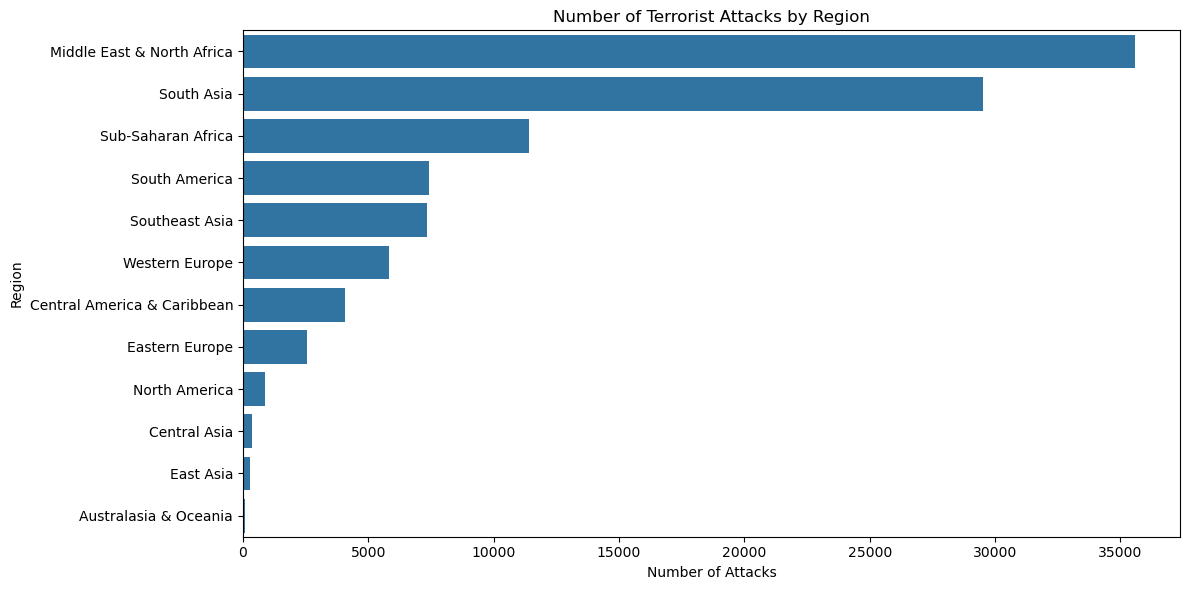

In [94]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='region_txt', order=df['region_txt'].value_counts().index)
plt.title('Number of Terrorist Attacks by Region')
plt.xlabel('Number of Attacks')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

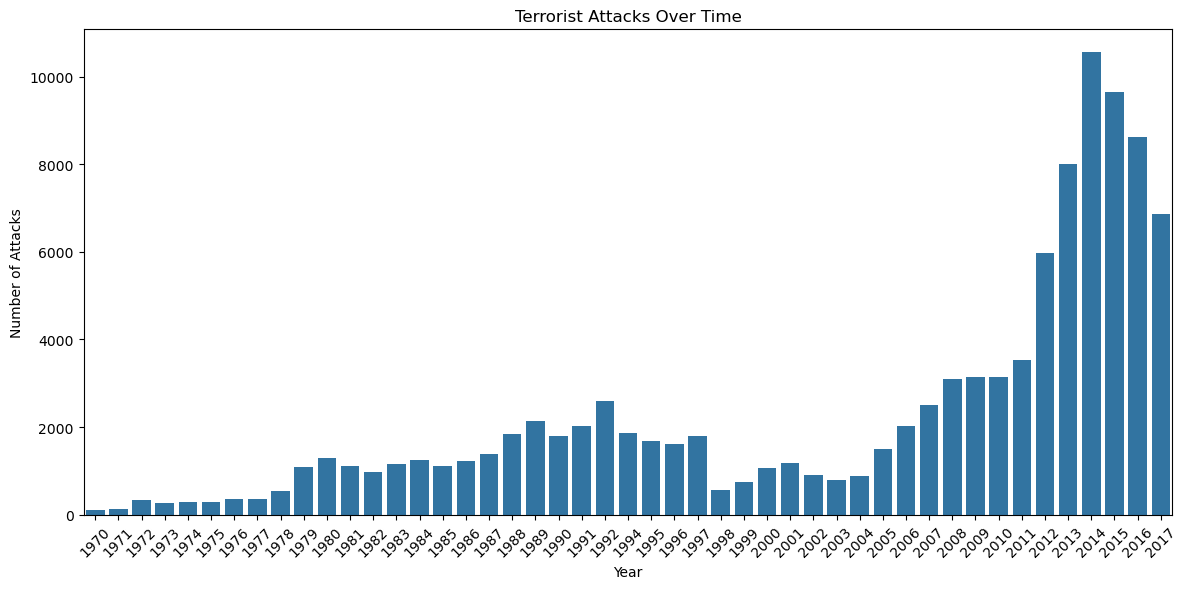

In [95]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='iyear')
plt.title('Terrorist Attacks Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Results

#### Baseline model
Now I am developing a baseline model to predict.

In [101]:
df['casualties'].value_counts(normalize=True).sort_values(ascending=False)

casualties
100.0     0.217220
1.0       0.085837
200.0     0.063903
2.0       0.047635
101.0     0.037252
            ...   
1663.0    0.000009
3642.0    0.000009
3189.0    0.000009
2805.0    0.000009
5181.0    0.000009
Name: proportion, Length: 2473, dtype: float64

Therefore, the baseline accuracy would be 20.87% if we always assumed each attack resulted in one fatality or the equivalent of 100 injuries.